<a href="https://colab.research.google.com/github/gerlaxrex/keras-seq2seq-models/blob/main/neural_machine_translation_lstm_seq2seq_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMT with Tensorflow and Keras

In this notebook we build a simple Encoder-Decoder Network with Attention mechanism using Tensorflow and Keras APIs.
The first network is built using only vanilla Tensorflow/Keras by creating three modules: Encoder, LuongAttention and Decoder.

After training and evaluating some sentences I use the Tensorflow Addons (tfa) library in order to train the model. In this case, the training step is customized in order to allow a better control over the various steps of the decoding process.

The decoding phase is greedy, but I plan to try also a Beam Search decoding.

The dataset is composed of english sentences and the italian translation of them. In this case, we try to translate from english to italian.

In [20]:
! pip install datatable
! pip install afinn
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import pandas as pd
import datatable as dt
import numpy as np
from sklearn.utils import shuffle
from afinn import Afinn

import sys, gc, re, time

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, GRU, Attention, concatenate, LSTMCell
import tensorflow_addons as tfa

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
NUM_DATA = 300_000
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

**WARNING**: Before doing this step you need to go to Kaggle and generate the API token for your personal account. Then upload here on Colab the "kaggle.json" file

In [23]:
! pip install kaggle
! mkdir ~/.kaggle
! \cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d balamurugan1603/nmtitalian2english
# ! kaggle datasets download -d yelp-dataset/yelp-dataset
! unzip nmtitalian2english.zip
# ! unzip yelp-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nmtitalian2english.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nmtitalian2english.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: _about.txt              
  inflating: ita.txt                 


# Data preparation

We perform a small preprocessing of the data consisting in:



1.   Shuffling the data once
2.   Insert a whitespace between a word and puntuation (?, !, ...)
3.   Reverse the source sentences (this is done in order to make the beginning of the sentence more "relevant" in the encoding phase)
4.   Add the special tokens for decoding in the form of "\<SOS\>" and "\<EOS\>".




In [24]:
dataset = dt.fread('../content/ita.txt',fill=True,header=False,columns=['en','it','info']).to_pandas()

In [25]:
def shuffle(df):
    np.random.shuffle(df.values)

def preprocess_sc(df):
    df['src'] = df['en'].map(lambda x : re.sub( r'([!?.,;])', r' \1', x)).map(lambda x : ' '.join(x.split()[::-1]))
    df['tgt'] = df['it'].map(lambda x : re.sub( r'([!?.,;])', r' \1', x))

def delete_na(df):
    df.dropna(inplace=True)

def add_special_symbols(df):
    df['tgt'] = df['tgt'].map(lambda x : '<SOS> ' + x + ' <EOS>') 

def preprocessing_text(df):
    shuffle(df)
    delete_na(df)
    preprocess_sc(df)
    add_special_symbols(df)
    df.drop(columns=['info','it','en'], inplace=True)
    return df

In [26]:
data = preprocessing_text(dataset)

In [27]:
data.iloc[100]

src                       . child a as Japan to came Tom
tgt    <SOS> Tom è venuto in Giappone da bambino . <EOS>
Name: 100, dtype: object

## Tokenization

In [28]:
tokenizer_src = Tokenizer(num_words=20_000, filters='"#$%&()*+-/=@[\\]^_`{|}~\t\n', oov_token='<oov>')
tokenizer_src.fit_on_texts(data['src'])

tokenizer_tgt = Tokenizer(num_words=20_000, filters='"#$%&()*+-/=@[\\]^_`{|}~\t\n', oov_token='<oov>')
tokenizer_tgt.fit_on_texts(data['tgt'])

In [29]:
src_sequences = tokenizer_src.texts_to_sequences(data['src'])
tgt_sequences = tokenizer_tgt.texts_to_sequences(data['tgt'])

In [30]:
max_src_len = max(len(s) for s in src_sequences)
max_tgt_len = max(len(s) for s in tgt_sequences)
print(max_src_len, max_tgt_len)

111 103


In [31]:
tot_length = len(src_sequences)
data_length = int(tot_length*0.8)
train_length = int(data_length*0.8)
valid_length = int(data_length*0.2)
test_length = int(tot_length*0.2)
print(f'Total data: {tot_length:_}, \ntraining data: {train_length:_}, \nValidation data: {valid_length:_}, \nTest data: {test_length:_}')

Total data: 352_035, 
training data: 225_302, 
Validation data: 56_325, 
Test data: 70_407


In [32]:
#Split the training, validation and test sets
train_idx_end, valid_idx_start = train_length, train_length
valid_idx_end = train_length+valid_length
test_idx_start = train_length+valid_length

train_sequences = [src_sequences[:train_idx_end], tgt_sequences[:train_idx_end]]
valid_sequences = [src_sequences[valid_idx_start:valid_idx_end], tgt_sequences[valid_idx_start:valid_idx_end]]
test_sequences = [src_sequences[test_idx_start:], tgt_sequences[test_idx_start:]]

In [33]:
# Try the preprocessing
src_str = ' '.join(tokenizer_src.index_word[i] for i in train_sequences[0][0])
tgt_str = ' '.join(tokenizer_tgt.index_word[i] for i in train_sequences[1][0])
src_str, tgt_str

('. truth the telling in hesitation no have i',
 '<sos> non ho alcuna esitazione a dire la verità . <eos>')

## Prepare the Dataset

In [50]:
BS_TRAIN = 64
BS_VALID = 32
SPE_TRAIN = len(train_sequences[0])//BS_TRAIN
SPE_VALID = len(valid_sequences[0])//BS_VALID
EPOCHS = 10

def create_dataset(src_seqs, tgt_seqs, bs_size, maxlen=20, padding='post'):
  tgt_1 = [w[:-1] for w in tgt_seqs]
  tgt_2 = [w[1:] for w in tgt_seqs]

  src_ds = tf.data.Dataset.from_tensor_slices((pad_sequences(src_seqs, maxlen=20, padding='post'), 
                                              pad_sequences(tgt_1, maxlen=20, padding='post')))
  tgt_ds = tf.data.Dataset.from_tensor_slices(pad_sequences(tgt_2, maxlen=20, padding='post'))

  gen_ds = tf.data.Dataset.zip((src_ds, tgt_ds))
  gen_ds = gen_ds.repeat().shuffle(1000).batch(bs_size).prefetch(1)
  return gen_ds

gen_train_ds = create_dataset(train_sequences[0], train_sequences[1], bs_size=BS_TRAIN)
gen_valid_ds = create_dataset(valid_sequences[0], valid_sequences[1], bs_size=BS_VALID)

## Encoder/Decoder Modeling


In [52]:
class Encoder(tf.keras.Model):
    
    def __init__(self, num_words, embedding_size=100, lstm_out_dim = 128, name='Encoder_model'):
        super(Encoder,self).__init__(name=name)
        self.lstm_output_dim = lstm_out_dim
        self.embedding_size = embedding_size
        self.embedding_layer = Embedding(input_dim=num_words+1,
                                         output_dim=self.embedding_size,
                                         mask_zero = True,
                                         name='Encoder_embedding')
        
        self.lstm_layer = LSTM(units = self.lstm_output_dim, 
                                return_sequences = True,
                                return_state = True, 
                                name='Encoder_LSTM')
    
    def call(self, inputs, init_state = None):
        #Return the whole sequence and the last state
        x = self.embedding_layer(inputs)
        mask = self.embedding_layer.compute_mask(inputs)
        outs, h, c = self.lstm_layer(x, mask = mask, initial_state = init_state)
        return outs, h, c

class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, latent_dim, name='Luong_Attention'):
    super().__init__()
    self.W1 = Dense(units=latent_dim)
    self.W2 = Dense(units=latent_dim)
    self.attn = Attention()

  def call(self, query, value):
    enc_states = self.W1(value)
    dec_last_state = self.W2(query)
    # print(enc_states.shape)
    # print(dec_last_state.shape)
    attn_out, attn_scores = self.attn([dec_last_state, enc_states], return_attention_scores=True)
    return attn_out, attn_scores

class Decoder(tf.keras.Model):

    def __init__(self, num_words, embedding_size = 100, lstm_out_dim = 128, name = 'Decoder_model'):
        super(Decoder,self).__init__(name=name)
        self.lstm_output_dim = lstm_out_dim
        self.embedding_size = embedding_size
        self.embedding_layer = Embedding(input_dim=num_words+1,
                                         output_dim=self.embedding_size,
                                         mask_zero=True,
                                         name = 'Decoder_embedding')
        
        self.lstm_layer = LSTM(units = self.lstm_output_dim, 
                               return_state = True, 
                               return_sequences = True, 
                               name='Decoder_LSTM')
        
        self.attention_layer = LuongAttention(embedding_size)
        self.dense_decode_layer = TimeDistributed(Dense(units = lstm_out_dim, activation='tanh'))

        self.final_layer = TimeDistributed(Dense(units = num_words))
    def call(self, inputs, encoder_states):
        # With teacher forcing we give in input the expected tgt[:-1] and compare the result with the tgt[1:]
        # Without teacher forcing we use the previous decoder output and state for the next step 
        # (this is why we return results and outputs/states).
        x = self.embedding_layer(inputs)
        mask = self.embedding_layer.compute_mask(inputs)
        out, h, c = self.lstm_layer(x, initial_state = encoder_states[1:], mask = mask)

        #Adding attention mechanism
        context_vector, attn_weights = self.attention_layer(out, encoder_states[0])
        concat_out = concatenate([context_vector, out])
        out = self.dense_decode_layer(concat_out)

        #Final results
        res = self.final_layer(out)   
        del x,out
        gc.collect()
        return res, h, c, attn_weights

Try encoder Shapes

In [53]:
encoder = Encoder(100)
a,b,c = encoder(tf.expand_dims(train_sequences[0][0], 0))
print(a.shape, b.shape, c.shape)

(1, 9, 128) (1, 128) (1, 128)


Try LuongAttention shapes and viz

Context vector shape: (1, 12, 100) - attention weights shape: (1, 12, 10)


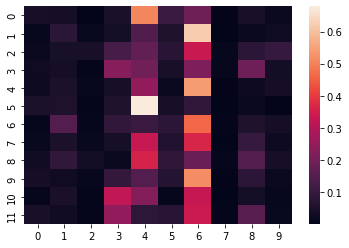

In [54]:
luong_attn = LuongAttention(latent_dim = 100)
value = np.random.rand(1,10,100) #Encoder states
query = np.random.rand(1,12,100) #Decoder outputs
masks = [np.ones((1,12), dtype=bool), np.ones((1,10), dtype=bool)]
context_vector, attn_weights = luong_attn(query, value)
print(f'Context vector shape: {context_vector.shape} - attention weights shape: {attn_weights.shape}')

sns.heatmap(tf.squeeze(attn_weights).numpy())

## Model Building

Build the Encoder/Decoder Graph

In [55]:
encoder_input = tf.keras.Input(shape=[None], name='Encoder_inputs')
decoder_input = tf.keras.Input(shape=[None], name='Decoder_inputs')

encoder = Encoder(num_words = len(tokenizer_src.word_index), embedding_size=50, lstm_out_dim=128)
decoder = Decoder(num_words = len(tokenizer_tgt.word_index), embedding_size=50, lstm_out_dim=128)

#Build the graph
outs, h_tot, c_tot = encoder(encoder_input)
print(outs.shape, h_tot.shape, c_tot.shape)


return_seq,_,_,_ = decoder(decoder_input, encoder_states=[outs, h_tot, c_tot])

seq2seq_model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=return_seq, name='Seq2Seq_Model')
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam(learning_rate=0.5e-3)
seq2seq_model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

(None, None, 128) (None, 128) (None, 128)


In [56]:
seq2seq_model.summary()
encoder.summary()
decoder.summary()

Model: "Seq2Seq_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 Decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 Encoder_model (Encoder)        ((None, None, 128),  787898      ['Encoder_inputs[0][0]']         
                                 (None, 128),                                                     
                                 (None, 128))                                                     
                                                                                      

In [57]:
# Define the callbacks for our model

callbacksList = [
                 tf.keras.callbacks.ModelCheckpoint('./chkpnt/model_saving', save_best_only=True, save_weights_only=True),
                 tf.keras.callbacks.EarlyStopping(patience=3)
                #  tf.keras.callbacks.TensorBoard()
                 ]

In [58]:
seq2seq_model.fit(gen_train_ds, 
                  epochs=EPOCHS, 
                  steps_per_epoch=SPE_TRAIN,
                  validation_data=gen_valid_ds,
                  validation_steps=SPE_VALID
                  )

Epoch 1/10
3520/3520 [==============================] - 374s 103ms/step - loss: 1.6475 - accuracy: 0.3260 - val_loss: 1.2493 - val_accuracy: 0.4457
Epoch 2/10
3520/3520 [==============================] - 359s 102ms/step - loss: 0.9967 - accuracy: 0.5365 - val_loss: 0.8059 - val_accuracy: 0.6108
Epoch 3/10
3520/3520 [==============================] - 359s 102ms/step - loss: 0.6899 - accuracy: 0.6535 - val_loss: 0.6328 - val_accuracy: 0.6764
Epoch 4/10
3520/3520 [==============================] - 359s 102ms/step - loss: 0.5467 - accuracy: 0.7067 - val_loss: 0.5374 - val_accuracy: 0.7124
Epoch 5/10
3520/3520 [==============================] - 359s 102ms/step - loss: 0.4643 - accuracy: 0.7364 - val_loss: 0.4833 - val_accuracy: 0.7323
Epoch 6/10
3520/3520 [==============================] - 358s 102ms/step - loss: 0.4093 - accuracy: 0.7559 - val_loss: 0.4451 - val_accuracy: 0.7460
Epoch 7/10
3520/3520 [==============================] - 358s 102ms/step - loss: 0.3691 - accuracy: 0.7709 - val_

In [59]:
# %load_ext tensorboard

In [60]:
# %tensorboard --logdir logs

In [61]:
def evaluate_sentence(sentence, debug=False, viz_attn=False):
  sentence = [re.sub(r'([!?.,;])', r' \1', sentence)]
  sentence = [' '.join(sentence[0].split()[::-1])]
  seq_sentence = tokenizer_src.texts_to_sequences(sentence)
  seq_sentence = tf.convert_to_tensor(seq_sentence)
  #Pass the sequence to the encoder
  enc_out, enc_h, enc_c = encoder(seq_sentence)
  dec_h = enc_h
  dec_c = enc_c

  out_seq = []
  eos_idx = tokenizer_tgt.word_index['<eos>']
  curr_output = [tokenizer_tgt.word_index['<sos>']]
  for i in range(20):
      dec_input = tf.convert_to_tensor(curr_output)
      dec_input = tf.expand_dims(dec_input, axis=0)
      if debug:
        print(f'Input: {dec_input}')
      out, h_, c_, _= decoder(dec_input, encoder_states=[enc_out, dec_h, dec_c])
      out_idx = tf.squeeze(tf.argmax(out, axis=-1))
      if debug:
        print(f'Next output: {out_idx}')
      dec_h = h_
      dec_c = c_
      
      if out_idx == eos_idx:
          break
      
      out_seq.append(out_idx.numpy())
      if debug:
        print(f'Output sequence: {out_seq}')
      curr_output = [out_idx.numpy()]

  print('Final sequence: '+' '.join(tokenizer_tgt.index_word[i] for i in out_seq))



In [62]:
evaluate_sentence("i want to kill you")
evaluate_sentence("What are you doing?")
evaluate_sentence("Is this a joke?")
evaluate_sentence("Not my problem")
evaluate_sentence("I'm bored")
evaluate_sentence("Is there something that is bothering you?")

Final sequence: io voglio uccidervi .
Final sequence: cosa fate ?
Final sequence: questa è una barzelletta ?
Final sequence: non il mio sapore .
Final sequence: io sono annoiato .
Final sequence: c'è qualcosa che ti sta disturbando ?


# Using TF-Addons: Seq2Seq module

The Encoder is already done. We need to define another type of Decoder that uses the Attention mechanism and the training sampler.

In [ ]:
class DecoderAddon(tf.keras.Model):

  def __init__(self, num_words, embedding_size = 100, lstm_out_dim = 128, name = 'Decoder_model'):
    super().__init__()
    self.num_words = num_words
    self.embedding_size = embedding_size
    self.lstm_out_dim = lstm_out_dim
    self.name
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()


    self.embedding_layer = Embedding(input_dim=num_words+1,
                                         output_dim=self.embedding_size,
                                         name = 'Decoder_embedding')
    
    self.rnn_cell = LSTMCell(units=lstm_out_dim,
                             name='Decoder_LSTM_Cell')
    
    self.attn_mechanism = tfa.seq2seq.LuongAttention(units=lstm_out_dim)
    self.recurrent_layer = tfa.seq2seq.AttentionWrapper(self.rnn_cell, 
                                                        self.attn_mechanism, 
                                                        attention_layer_size=self.lstm_out_dim)
    self.prediction_layer = Dense(units=self.num_words)
    self.decoder_layer = tfa.seq2seq.BasicDecoder(self.recurrent_layer, sampler=self.sampler, output_layer=self.prediction_layer)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.recurrent_layer.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state  

  def call(self, inputs, encoder_states):
    x = self.embedding_layer(inputs)
    mask = self.embedding_layer.compute_mask(inputs)
    outputs, _, _ = self.decoder_layer(x, initial_state=encoder_states, mask = mask)
    return outputs

In [ ]:
encoder_addon = Encoder(len(tokenizer_src.word_index), embedding_size=50, lstm_out_dim=128)
decoder_addon = DecoderAddon(len(tokenizer_tgt.word_index), embedding_size=50, lstm_out_dim=128)

In [65]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

In [66]:
@tf.function
def train_step(enc_inp, dec_inp, dec_out, enc_hidden=None):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder_addon(enc_inp, enc_hidden)

    # Set the AttentionMechanism object with encoder_outputs
    decoder_addon.attn_mechanism.setup_memory(enc_output)

    # Create AttentionWrapperState as initial_state for decoder
    decoder_initial_state = decoder_addon.build_initial_state(BS_TRAIN, [enc_h, enc_c], tf.float32)
    pred = decoder_addon(dec_inp, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_fn(dec_out, logits)
    reshaped_logits = tf.reshape(tf.nn.softmax(logits), (logits.shape[0],dec_out.shape[-1], logits.shape[-1]))
    #Update metric state
    metric_fn.update_state(dec_out, reshaped_logits)

  variables = encoder_addon.trainable_variables + decoder_addon.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss

@tf.function
def valid_step(enc_inp, dec_inp, dec_out, enc_hidden=None):
  loss = 0

  enc_output, enc_h, enc_c = encoder_addon(enc_inp, enc_hidden)
  decoder_addon.attn_mechanism.setup_memory(enc_output)
  # Create AttentionWrapperState as initial_state for decoder
  decoder_initial_state = decoder_addon.build_initial_state(BS_VALID, [enc_h, enc_c], tf.float32)
  pred = decoder_addon(dec_inp, decoder_initial_state)
  logits = pred.rnn_output
  loss = loss_fn(dec_out, logits)
  reshaped_logits = tf.reshape(tf.nn.softmax(logits), (logits.shape[0],dec_out.shape[-1], logits.shape[-1]))
  #Update metric state
  metric_fn.update_state(dec_out, reshaped_logits)

  return loss

In [ ]:
print('Started training.')
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = None
  total_loss = 0
  total_acc = 0
  valid_loss = 0
  valid_acc = 0

  #Train on dataset
  metric_fn.reset_state()
  for (batch, ((enc_inp, dec_inp), dec_out)) in enumerate(gen_train_ds.take(SPE_TRAIN)):
    batch_loss = train_step(enc_inp, dec_inp, dec_out, enc_hidden)
    total_loss += batch_loss
    total_acc = metric_fn.result()

    if batch % 100 == 0:
      print('\r '*200,end='')
      print('\rTrain Epoch {} Batch {} Loss {:.3f} Accuracy {:.3f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy(),
                                                   total_acc),end='')
  metric_fn.reset_state()
  print('-----')
  for (batch, ((enc_inp, dec_inp), dec_out)) in enumerate(gen_valid_ds.take(SPE_VALID)):
    batch_valid_loss = valid_step(enc_inp, dec_inp, dec_out, enc_hidden)
    valid_loss += batch_valid_loss
    valid_acc = metric_fn.result()

    if batch % 100 == 0:
      print('\r '*200)
      print('\rValid Epoch {} Batch {} Loss {:.4f} Accuracy {:.3f}'.format(epoch + 1,
                                                   batch,
                                                   valid_loss.numpy(),
                                                   valid_acc), end='')
    
  print(f'Epoch {epoch+1} - ({time.time()-start}s) - Loss {total_loss/SPE_TRAIN:.3f} - Acc. {total_acc:.3f} - Val.Loss {valid_loss/SPE_VALID:.3f} - Val.Acc {valid_acc:.3f}')

Started training.
Train Epoch 1 Batch 1800 Loss 0.456 Accuracy 0.881

In [ ]:
def evaluate_sentence(sentence_in, debug=False, viz_attn=False):
  sentence = [re.sub(r'([!?.,;])', r' \1', sentence_in)]
  sentence = [' '.join(sentence[0].split()[::-1])]
  seq_sentence = tokenizer_src.texts_to_sequences(sentence)
  seq_sentence = tf.convert_to_tensor(seq_sentence)
  #Pass the sequence to the encoder

  enc_start_state = [tf.zeros((1, encoder_addon.lstm_output_dim)), tf.zeros((1, encoder_addon.lstm_output_dim))]
  enc_out, enc_h, enc_c = encoder_addon(seq_sentence)

  out_seq = []
  eos_idx = tokenizer_tgt.word_index['<eos>']
  curr_output = [tokenizer_tgt.word_index['<sos>']]

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
  decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder_addon.recurrent_layer, sampler=greedy_sampler, output_layer=decoder_addon.prediction_layer)
  decoder_addon.attn_mechanism.setup_memory(enc_out)
  # set decoder_initial_state
  decoder_initial_state = decoder_addon.build_initial_state(1, [enc_h, enc_c], tf.float32)


  ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
  ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
  ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function

  decoder_embedding_matrix = decoder_addon.embedding_layer.variables[0]

  outputs, _, _ = decoder_instance(decoder_embedding_matrix, start_tokens = curr_output, end_token= eos_idx, initial_state=decoder_initial_state)
  out_seq = outputs.sample_id.numpy().squeeze()
  print(f'Original sentence: {sentence_in}')
  print('Final sequence: '+' '.join(tokenizer_tgt.index_word[i] for i in out_seq[:-1]))

In [ ]:
evaluate_sentence('I need to talk!')